In [1]:
from lec_utils import *
import re

<div class="alert alert-info" markdown="1">

#### Lecture 12

# Text as Data

### EECS 398-003: Practical Data Science, Fall 2024

<small><a style="text-decoration: none" href="https://practicaldsc.org">practicaldsc.org</a> • <a style="text-decoration: none" href="https://github.com/practicaldsc/fa24">github.com/practicaldsc/fa24</a></small>
    
</div>

### Announcements 📣

- Homework 5 is due **tonight**. It includes a required [**Pre-Midterm Survey**](https://docs.google.com/forms/d/e/1FAIpQLSfCT2TfFUWF0gbnfuV_at0bG3w0Za9-KuLIA7cpZm0NL5jbKQ/viewform).<br><small>Homework 6 will be released later this week, but won't be due until after Fall Break.</small>
- The Midterm Exam is on **Wednesday, October 9th from 7-9PM**.
    - Lectures 1-12 and Homeworks 1-6 are in scope.
    - The lecture before the exam will be review, and the TAs will run a review session on **Monday from 6-8PM in FXB 1109** too.
    - You can bring **one double-sided 8.5"x11" notes sheet that you handwrite yourself (no printing, no using an iPad, etc.)**.
    - Work through old exam problems [**here**](https://study.practicaldsc.org/).
- Looking for sources of data, or other supplemental resources? Look at our updated [**Resources**](https://practicaldsc.org/resources) page!

### Aside: Following along with lecture

- I've read the feedback, and I'll try and type slower and have slightly more of the code filled in the notebook before presenting.

- But, remember that **all** of the code I write live is posted **before lecture** – click the **📝 filled html** buttons to see these (or open `lecXX-filled.ipynb`).

### Agenda

- From text to numbers.
- Bag of words 💰.
- TF-IDF.
- Example: State of the Union addresses 🎤.

<div class="alert alert-success" markdown="1">
    <h3>Activity</h3><br><small>This is an old exam question!</small>

<center><img src="imgs/practice.png" width=1400></center>

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a style="text-decoration: none; color: #0066cc" href="https://docs.google.com/forms/d/e/1FAIpQLSd4oliiZYeNh76jWy-arfEtoAkCrVSsobZxPwxifWggo3EO0Q/viewform">practicaldsc.org/q</a>)</h3>
    
<small>Remember that you can always ask questions anonymously at the link above!</small>

## From text to numbers

---

### From text to numbers

- How do we represent a **text** document using **numbers**?

- Computers and mathematical formulas are designed to work with numbers, not words.

- So, if we can convert documents into numbers, we can:
    - **summarize** documents by finding their most important words (today).
    - **quantify** the similarity of two documents (today).
    - use a document as input in a regression or classification model (second half of the semester).

### Example: State of the Union addresses 🎤

- Each year, the sitting US President delivers a "State of the Union" address. The 2024 State of the Union (SOTU) address was on March 7th, 2024.<br><small>"Address" is another word for "speech."</small>

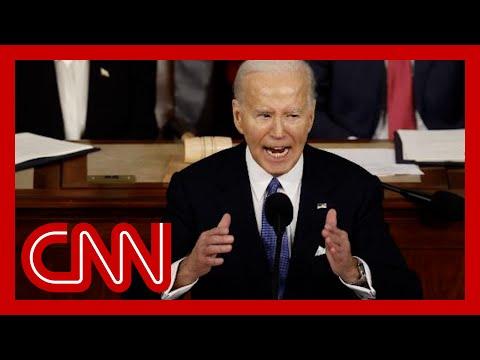

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('cplSUhU2avc')

- The file `'data/stateoftheunion1790-2024.txt'` contains the transcript of every SOTU address since 1790.

In [3]:
with open('data/stateoftheunion1790-2024.txt') as f:
    sotu = f.read()

In [4]:
# The file is over 10 million characters long!
len(sotu) / 1_000_000

10.616051

### Terminology

- In text analysis, each piece of text we want to analyze is called a **document**.<br><small>Here, each speech is a document.</small>

- Documents are made up of **terms**, i.e. words.

- A collection of documents is called a **corpus**.<br><small>Here, the corpus is the set of all SOTU speeches from 1790-2024.</small>

### Extracting speeches

- In the string `sotu`, each document is separated by `'***'`.

In [5]:
speeches_lst = sotu.split('\n***\n')[1:]
len(speeches_lst)

234

- Note that each "speech" currently contains other information, like the name of the president and the date of the address.

In [6]:
print(speeches_lst[-1][:1000])


State of the Union Address
Joseph R. Biden Jr.  
March 7, 2024

Good evening. 

Mr. Speaker. Madam Vice President. Members of Congress. My Fellow Americans. 

In January 1941, President Franklin Roosevelt came to this chamber to speak to the nation. 

He said, “I address you at a moment unprecedented in the history of the Union.” 

Hitler was on the march. War was raging in Europe. 

President Roosevelt’s purpose was to wake up the Congress and alert the American people that this was no ordinary moment.   

Freedom and democracy were under assault in the world. 

Tonight I come to the same chamber to address the nation. 

Now it is we who face an unprecedented moment in the history of the Union. 

And yes, my purpose tonight is to both wake up this Congress, and alert the American people that this is no ordinary moment either. 

Not since President Lincoln and the Civil War have freedom and democracy been under assault here at home as they are today. 

What makes our moment rare is th

- Let's extract just the text of each speech and put it in a DataFrame.<br><small>Along the way, we'll use our new knowledge of regular expressions to remove capitalization and punctuation, so we can just focus on the content itself.</small>

In [7]:
def create_speeches_df(speeches_lst):
    def extract_struct(speech):
        L = speech.strip().split('\n', maxsplit=3)
        L[3] = re.sub(r"[^A-Za-z' ]", ' ', L[3]).lower() # Replaces anything OTHER than letters with ' '.
        L[3] = re.sub(r"it's", 'it is', L[3])
        return dict(zip(['president', 'date', 'text'], L[1:]))
    speeches = pd.DataFrame(list(map(extract_struct, speeches_lst)))
    speeches.index = speeches['president'].str.strip() + ': ' + speeches['date']
    speeches = speeches[['text']]
    return speeches

In [8]:
speeches = create_speeches_df(speeches_lst)
speeches

,text
"George Washington: January 8, 1790",fellow citizens of the senate and house of re...
"George Washington: December 8, 1790",fellow citizens of the senate and house of re...
"George Washington: October 25, 1791",fellow citizens of the senate and house of re...
...,...
"Joseph R. Biden Jr.: March 1, 2022",madam speaker madam vice president and our ...
"Joseph R. Biden Jr.: February 7, 2023",mr speaker madam vice president our firs...
"Joseph R. Biden Jr.: March 7, 2024",good evening mr speaker madam vice presi...


### Quantifying speeches

- Our goal is to produce a DataFrame that contains the **most important terms** in each speech, i.e. the terms that **best summarize** each speech:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>most important terms</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>George Washington: January 8, 1790</th>
      <td>your, proper, regard, ought, object</td>
    </tr>
    <tr>
      <th>George Washington: December 8, 1790</th>
      <td>case, established, object, commerce, convention</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
    </tr>
    <tr>
      <th>Joseph R. Biden Jr.: February 7, 2023</th>
      <td>americans, down, percent, jobs, tonight</td>
    </tr>
    <tr>
      <th>Joseph R. Biden Jr.: March 7, 2024</th>
      <td>jobs, down, get, americans, tonight</td>
    </tr>
  </tbody>
</table>

- To do so, we will need to come up with a way of assigning a **numerical score** to each term in each speech.<br><small>We'll come up with a score for each term such that terms with **higher scores** are **more important**!</small>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>jobs</th>
      <th>down</th>
      <th>commerce</th>
      <th>...</th>
      <th>convention</th>
      <th>americans</th>
      <th>tonight</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>George Washington: January 8, 1790</th>
      <td>0.00e+00</td>
      <td>0.00e+00</td>
      <td>3.55e-04</td>
      <td>...</td>
      <td>0.00e+00</td>
      <td>0.00e+00</td>
      <td>0.00e+00</td>
    </tr>
    <tr>
      <th>George Washington: December 8, 1790</th>
      <td>0.00e+00</td>
      <td>0.00e+00</td>
      <td>1.10e-03</td>
      <td>...</td>
      <td>1.18e-03</td>
      <td>0.00e+00</td>
      <td>0.00e+00</td>
    </tr>
    <tr>
        <th>...</th>
        <td>...</td>
        <td>...</td>
        <td>...</td>
        <td>...</td>
        <td>...</td>
        <td>...</td>
        <td>...</td>
    </tr>
    <tr>
      <th>Joseph R. Biden Jr.: February 7, 2023</th>
      <td>2.73e-03</td>
      <td>1.78e-03</td>
      <td>0.00e+00</td>
      <td>...</td>
      <td>0.00e+00</td>
      <td>1.56e-03</td>
      <td>3.34e-03</td>
    </tr>
    <tr>
      <th>Joseph R. Biden Jr.: March 7, 2024</th>
      <td>1.77e-03</td>
      <td>1.96e-03</td>
      <td>5.93e-05</td>
      <td>...</td>
      <td>0.00e+00</td>
      <td>2.37e-03</td>
      <td>3.90e-03</td>
    </tr>
  </tbody>
</table>

- In doing so, we will represent each speech as a **vector**.

## Bag of words 💰

---

### Counting frequencies

- **Idea**: The most important terms in a document are the terms that occur most often.

- So, let's count the number of occurrences of each term in each document.<br><small>In other words, let's count the **frequency** of each term in each document.</small>

- For example, consider the following three documents:

<div align="center"><b>
big big big big data class<br>
data big data science<br>
science big data
    </b></div>

- Let's construct a matrix, where:
    - there is one row per **document**,
    - one column per unique **term**, and
    - the value in row $d$ and column $t$ is the **number of occurrences of term $t$ in document $d$**.

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

### Bag of words

- The **bag of words** model represents documents as **vectors of word counts**, i.e. **term frequencies**.<br><small>The matrix below was created using the bag of words model.</small>

- Each **row** in the bag of words matrix is a **vector representation** of a document.

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

- For example, we can represent the document 2, **data big data science**, with the vector $\vec{d_2}$:

$$\vec{d_2} = \begin{bmatrix} 1 \\ 2 \\ 0 \\ 1 \end{bmatrix}$$

<center><img src='imgs/bag-of-words.jpeg' width=1000></center>

<center><a href="https://42f6861cgkip12ijm63i3orf-wpengine.netdna-ssl.com/wp-content/uploads/2020/12/2020-07-bagofwords.jpg">(source)</a></center>

<br>

<center markdown="1">It is called "bag of words" because it doesn't consider <b>order</b>.</center>

### Aside: Interactive bag of words demo

Check [this](https://svelte.dev/repl/98d158ef6fb842d09c66ed20b9a31e99?version=3.55.1) site out – it automatically generates a bag of words matrix for you!

<center><img src='imgs/bow-interactive.png' width=50%>(<a href="https://twitter.com/jdwlbr/status/1622704535511916544?s=20">source</a>)</center>

### Applications of the bag of words model

- Now that we have a matrix of word counts, what can we do with it?

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

- **Application**: We _could_ interpret the term with the largest value – that is, the **most frequent term** – in each document as being the most important.<br><small>This is imperfect. What if a document has the term "the" as its most frequent term?</small>

- **Application**: We could use the **vector** representations of documents to measure the **similarity** of two documents.<br><small>This would enable us to find, for example, the SOTU speeches that are most similar to one another!</small>

### Recall: The dot product

$$\require{color}$$

<div style="width: 100%;">
<div style="width: 65%; float: left"> 

- Recall, if $\color{purple} \vec{u} = \begin{bmatrix} u_1 \\ u_2 \\ ... \\ u_n \end{bmatrix}$ and $\color{#007aff} \vec{v} = \begin{bmatrix} v_1 \\ v_2 \\ ... \\ v_n \end{bmatrix}$ are two vectors, then their <b>dot product</b> ${\color{purple}\vec{u}} \cdot {\color{#007aff}\vec{v}}$ is defined as:

$${\color{purple}\vec{u}} \cdot {\color{#007aff}\vec{v}} = \sum_{i = 1}^n {\color{purple}u_i} {\color{#007aff} v_i} = {\color{purple}u_1} {\color{#007aff} v_1} + {\color{purple}u_2} {\color{#007aff} v_2} + ... + {\color{purple}u_n} {\color{#007aff} v_n}$$

- The dot product also has an equivalent **geometric** definition, which says that:

$${\color{purple}\vec{u}} \cdot {\color{#007aff}\vec{v}} = \lVert {\color{purple}\vec{u}} \rVert \lVert {\color{#007aff}\vec{v}} \rVert \cos \theta$$

<center><small>where $\theta$ is the angle between $\color{purple}\vec{u}$ and ${\color{#007aff}\vec{v}}$, and<br>$\lVert {\color{purple}\vec{u}} \rVert = \sqrt{{\color{purple} u_1}^2 + {\color{purple} u_2}^2 + ... + {\color{purple} u_n}^2}$<br>is the length of $\color{purple} \vec u$.</small></center>
    
- The two definitions are equivalent! This equivalence allows us to find the angle $\theta$ between two vectors.
    
- For review, see [**LARDS, Section 2**](https://practicaldsc.org/lin-alg/#the-dot-product-angles-and-orthogonality).
    
</div>
    <div style="margin-left: 65%; height: 100px;" markdown="1"> 

<center>
<img src="imgs/theta-1-unlabeled.png" width=600>
</center>

</div>
</div>


### Angles and similarity

- <b>Key idea</b>: The more similar two vectors are, the <b>smaller</b> the angle $\theta$ between them is.

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="imgs/theta-2.png" width="415">
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="imgs/theta-1.png" width="400">
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="imgs/theta-3.png" width="415">
    </div>
</div>

- The smaller the angle $\theta$ between two vectors is, the **larger** $\cos \theta$ is.

- The maximum value of $\cos \theta$ is 1, achieved when $\theta = 0$.

- **Key idea: The more similar two vectors are, the larger $\cos \theta$ is!**

### Cosine similarity

- To measure the similarity between two documents, we can compute the **cosine similarity** of their vector representations:

$$\text{cosine similarity}(\vec u, \vec v) = \cos \theta = \boxed{\frac{\vec{u} \cdot \vec{v}}{|\vec{u}| | \vec{v}|}}$$

- If all elements in $\vec{u}$ and $\vec{v}$ are non-negative, then $\cos \theta$ ranges from 0 to 1.

- **Key idea: The more similar two vectors are, the larger $\cos \theta$ is!**

- Given a collection of documents, to find the most similiar **pair**, we can:
    1. Find the vector representation of each document.
    2. Find the cosine similarity of each pair of vectors.
    3. Return the documents whose vectors had the **largest** cosine similarity.

<div class="alert alert-success">
    <h3>Activity</h3>

Consider the matrix of word counts we found earlier, using the bag of words model:
                
| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

1. Which two documents have the highest **dot product**?
2. Which two documents have the highest **cosine similarity**?
    
</div>

### Normalizing

- Why can't we just use the dot product – that is, why must we divide by $|\vec{u}| | \vec{v}|$ when computing cosine similarity?

$$\text{cosine similarity}(\vec u, \vec v) = \cos \theta = \boxed{\frac{\vec{u} \cdot \vec{v}}{|\vec{u}| | \vec{v}|}}$$

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

- Consider the following two _pairs_ of documents:

| Pair | Dot Product | Cosine Similarity |
| --- | --- | --- |
| **big big big big data class** and **data big data science** | 6 | 0.577 |
| **science big data** and **data big data science** | 4 | 0.943 |

- **"big big big big data class"** has a large dot product with **"data big data science"** just because the former has the term **"big"** four times. But intuitively, **"data big data science"** and **"science big data"** should be much more similar, since they have almost the exact same terms.

- **So, make sure to compute the cosine similarity – don't just use the dot product!**<br><small>If you don't normalize by the lengths of the vectors, documents with more terms will have artificially high similarities with other documents.</small>

<div class="alert alert-danger" markdown="1">

#### Reference Slide

### Cosine distance

- Sometimes, you will see the **cosine distance** being used. It is the complement of cosine similarity:
  
$$\text{dist}(\vec{u}, \vec{v}) = 1 - \text{cosine similarity}(\vec u, \vec v) = 1 - \cos \theta$$

- If $\text{dist}(\vec{u}, \vec{v})$ is small, the two vector representations are similar.

### Issues with the bag of words model

- Recall, the bag of words model encodes a document as a vector containing **word frequencies**.

- It doesn't consider the **order** of the terms.
<br><small>**"big data science"** and **"data science big"** have the same vector representation, but mean different things.</small>

- It doesn't consider the **meaning** of terms.<br><small>**"I really really hate data"** and **"I really really love data"** have nearly identical vector representations, but very different meanings.</small>

- It treats all words as being equally important. **This is the issue we'll address today.**<br><small>In **"I am a student"** and **"I am a teacher"**, it's clear to us humans that the most important terms are **"student"** and **"teacher"**, respectively. But in the bag of words model, **"student"** and **"I"** appear the same number of times in the first document.</small>

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a style="text-decoration: none; color: #0066cc" href="https://docs.google.com/forms/d/e/1FAIpQLSd4oliiZYeNh76jWy-arfEtoAkCrVSsobZxPwxifWggo3EO0Q/viewform">practicaldsc.org/q</a>)</h3>
    
<small>Remember that you can always ask questions anonymously at the link above!</small>
    
What questions do you have?

## TF-IDF

---

### What makes a word important?

- **Issue**: The bag of words model doesn't know which terms are "important" in a document.

- Consider the following document:

<center>"my brother has a friend named <b>billy</b> who has an uncle named <b>billy</b>"</center>


- **"has"** and **"billy"** both appear the same number of times in the document above. But **"has"** is an extremely common term overall, while **"billy"** isn't.

- **Observation**: If a term is important in a document, it will **appear frequently in that document** but **not frequently in other documents**.<br><small>Let's try and find a way of giving **scores** to terms that keeps this in mind. If we can do this, then the terms with the highest scores can be used to summarize the document!</small>

### Term frequency

- The **term frequency** of a term $t$ in a document $d$, denoted $\text{tf}(t, d)$, is the proportion of words in document $d$ that are equal to $t$.

$$\text{tf}(t, d) = \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of terms in $d$}}$$

- **Example**: What is the term frequency of "billy" in the following document?

<center>"my brother has a friend named <b>billy</b> who has an uncle named <b>billy</b>"</center>

- **Answer**: $\frac{2}{13}$.

- Intuition: Terms that occur often within a document are important to the document's meaning.

$$\text{tf}(t, d) \text{ large} \implies t \text{ occurs often in $d$} \\ \text{tf}(t, d) \text{ small} \implies t \text{ occurs rarely in $d$}$$

- Issue: **"has"** also has a TF of $\frac{2}{13}$, but it seems less important than **"billy"**.

### Inverse document frequency

- The **inverse document frequency** of a term $t$ in a **set** of documents $d_1, d_2, ...$ is:

$$\text{idf}(t) = \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right)$$

- **Example**: What is the inverse document frequency of **"billy"** in the following three documents?
    - "my brother has a friend named **billy** who has an uncle named **billy**"
    - "my favorite artist is named jilly boel"
    - "why does he talk about someone named **billy** so often"

- **Answer**: $\log \left(\frac{3}{2}\right) \approx 0.4055$.<br><small>Here, we used the natural logarithm. It doesn't matter which log base we use, as long as we keep it consistent throughout all of our calculations.</small>

- Intuition: If a word appears in every document (like **"the"** or **"has"**), it is probably not a good summary of any one document.

- Think of $\text{idf}(t)$ as the "rarity factor" of $t$ across documents – the larger $\text{idf}(t)$ is, the more rare $t$ is.

$$\text{idf}(t) \text{ large} \implies t \text{ rare across all documents} \\ \text{idf}(t) \text{ small} \implies t \text{ common across all documents}$$

### Intuition

- **Goal**: Measure how important term $t$ is to document $d$.<br><small>Equivalent goal: Find the terms that best summarize $d$.</small>

$$\text{tf}(t, d) = \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of terms in $d$}}$$

$$\text{idf}(t) = \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right)$$

- If $\text{tf}(t, d)$ is small, then $t$ doesn't occur very often in $d$, so $t$ can't be very important to $d$.

- If $\text{idf}(t)$ is small, then $t$ occurs often amongst all documents, and so it can't be very important to $d$ specifically.

- If $\text{tf}(t, d)$ and $\text{idf}(t)$ are both large, then **$t$ occurs often in $d$ but rarely overall**. This makes $t$ **important** to $d$, i.e. a good "summary" of $d$.

### Term frequency-inverse document frequency

- The **term frequency-inverse document frequency (TF-IDF)** of term $t$ in document $d$ is the product:

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of terms in $d$}} \cdot \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right) \end{align*} $$

- If $\text{tfidf}(t, d)$ is large, then $t$ is important to $d$, because $t$ occurs often in $d$ but rarely across all documents.<br><small>This means $t$ is a good summary of $d$!</small>

- Note: TF-IDF is a **heuristic** method – there's no "proof" that it performs well.

- To know if $\text{tfidf}(t, d)$ is large for one particular term $t$, we need to compare it to $\text{tfidf}(t_i, d)$, for several different terms $t_i$.

### Computing TF-IDF

- **Question**: What is the TF-IDF of **"science"** in **"data big data science"**?


| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

- **Answer**:

$$\begin{align*}\text{tfidf}(t, d) &= \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of terms in $d$}} \cdot \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right) \\ &= \frac{1}{4} \cdot \log\left( \frac{3}{2} \right)\end{align*} $$

- **Question**: Is this big or small? Is **"science"** the **best** summary of **"data big data science"**?

### TF-IDF of all terms in all documents

- On its own, the TF-IDF of one term in one document doesn't really tell us anything. We must compare it to TF-IDFs of other terms in that same document.

- Let's start with a DataFrame version of our bag of words matrix. It already contains the numerators for term frequency, i.e. $\text{tf}(t, d) = \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of terms in $d$}}$.

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

In [ ]:
bow = pd.DataFrame([[4, 1, 1, 0], [1, 2, 0, 1], [1, 1, 0, 1]],
                   index=['big big big big data class', 'data big data science', 'science big data'],
                   columns=['big', 'data', 'class', 'science'])
bow

- To convert the term counts to **term frequencies**, we'll divide by the sum of each **row**.<br><small>Each row corresponds to the terms in one document; the sum of a row is the total number of terms in the document, which is the denominator in $\text{tf}(t, d) = \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of terms in $d$}}$.</small>

In [ ]:
# Verify that each row sums to 1!
tfs = bow.apply(lambda s: s / s.sum(), axis=1) 
tfs

- Next, we need to find the **inverse document frequency** of each term, $t$, where $\text{idf}(t) = \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right)$.

In [ ]:
def idf(term):
    term_column = tfs[term]
    return np.log(term_column.shape[0] / (term_column > 0).sum())

In [ ]:
idf('class') == np.log(3 / 1)

In [ ]:
all_idfs = [idf(c) for c in tfs.columns] 
all_idfs

In [ ]:
all_idfs = pd.Series(all_idfs, index=tfs.columns)
all_idfs

- Finally, let's multiply `tfs`, the DataFrame with the term frequencies of each term in each document, by `all_idfs`, the Series of inverse document frequencies of each term.

In [ ]:
tfidfs = tfs * all_idfs 
tfidfs

### Interpreting TF-IDFs

In [ ]:
tfidfs

- The TF-IDF of `'class'` in the first sentence is $\approx 0.18$.

- The TF-IDF of `'data'` in the second sentence is 0.

- Note that there are two ways that $\text{tfidf}(t, d) = \text{tf}(t, d) \cdot \text{idf}(t)$ can be 0:
    - If $t$ appears in every document, because then $\text{idf}(t) = \log (\frac{\text{# documents}}{\text{# documents}}) = \log(1) = 0$.
    - If $t$ does not appear in document $d$, because then $\text{tf}(t, d) = \frac{0}{\text{len}(d)} = 0$.

- The term that **best summarizes** a document is the term with the highest TF-IDF for that document:

In [ ]:
tfidfs.idxmax(axis=1) 

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a style="text-decoration: none; color: #0066cc" href="https://docs.google.com/forms/d/e/1FAIpQLSd4oliiZYeNh76jWy-arfEtoAkCrVSsobZxPwxifWggo3EO0Q/viewform">practicaldsc.org/q</a>)</h3>
    
<small>Remember that you can always ask questions anonymously at the link above!</small>
    
What questions do you have?

## Example: State of the Union addresses 🎤

---

### Overview

- Now that we have a robust technique for assigning scores to terms – that is, TF-IDF – we can use it to find the most important terms in each State of the Union address.

In [9]:
speeches

,text
"George Washington: January 8, 1790",fellow citizens of the senate and house of re...
"George Washington: December 8, 1790",fellow citizens of the senate and house of re...
"George Washington: October 25, 1791",fellow citizens of the senate and house of re...
...,...
"Joseph R. Biden Jr.: March 1, 2022",madam speaker madam vice president and our ...
"Joseph R. Biden Jr.: February 7, 2023",mr speaker madam vice president our firs...
"Joseph R. Biden Jr.: March 7, 2024",good evening mr speaker madam vice presi...


- To recap, we'll need to compute:

```
        for each term t:
            for each speech d:
                compute tfidf(t, d)
```

- This time, we don't already have a bag of words matrix, so we'll need to start from scratch.

### Finding all unique terms

- First, we need to find the unique terms used across all SOTU speeches.<br><small>These words will form the **columns** of our TF-IDF matrix.</small>

In [10]:
all_unique_terms = speeches['text'].str.split().explode().value_counts() # Faster than .sum() from last lecture! 
all_unique_terms

text
the        147338
of          94505
to          60827
            ...  
palacio         1
not'            1
isn             1
Name: count, Length: 24259, dtype: int64

- Since there are over 20,000 unique terms, our future calculations will otherwise take too much time to run. Let's take the 500 most frequent, across all speeches, for speed.

In [11]:
unique_terms = all_unique_terms.iloc[:500].index 
unique_terms

Index(['the', 'of', 'to', 'and', 'in', 'a', 'that', 'for', 'be', 'our',
       ...
       'months', 'call', 'increasing', 'desire', 'submitted', 'throughout',
       'point', 'trust', 'set', 'object'],
      dtype='object', name='text', length=500)

### Finding term frequencies

- Next, let's find the bag of words matrix, i.e. a matrix that tells us the number of occurrences of each term in each document.

- What's the difference between the following two expressions?

In [12]:
speeches['text'].str.count('the')

George Washington: January 8, 1790       120
George Washington: December 8, 1790      160
George Washington: October 25, 1791      302
                                        ... 
Joseph R. Biden Jr.: March 1, 2022       514
Joseph R. Biden Jr.: February 7, 2023    507
Joseph R. Biden Jr.: March 7, 2024       398
Name: text, Length: 234, dtype: int64

In [13]:
# Remember, the \b special character matches **word boundaries**!
# This makes sure that we don't count instances of "the" that are part of other words,
# like "thesaurus".
speeches['text'].str.count(r'\bthe\b')

George Washington: January 8, 1790        97
George Washington: December 8, 1790      122
George Washington: October 25, 1791      242
                                        ... 
Joseph R. Biden Jr.: March 1, 2022       357
Joseph R. Biden Jr.: February 7, 2023    338
Joseph R. Biden Jr.: March 7, 2024       296
Name: text, Length: 234, dtype: int64

- Let's repeat the above calculation for every unique term. This code will take a while to run, so we'll use the `tdqm` package to track its progress.<br><small>Install with `mamba install tqdm` if needed.</small>

In [14]:
from tqdm.notebook import tqdm
counts_dict = {}
for term in tqdm(unique_terms):
    counts_dict[term] = speeches['text'].str.count(fr'\b{term}\b')        
counts = pd.DataFrame(counts_dict, index=speeches.index)
counts

  0%|          | 0/500 [00:00<?, ?it/s]

,the,of,to,and,...,point,trust,set,object
"George Washington: January 8, 1790",97,69,56,41,...,0,1,0,3
"George Washington: December 8, 1790",122,89,49,45,...,0,0,0,2
"George Washington: October 25, 1791",242,159,88,73,...,0,2,2,2
...,...,...,...,...,...,...,...,...,...
"Joseph R. Biden Jr.: March 1, 2022",357,189,272,316,...,3,3,3,0
"Joseph R. Biden Jr.: February 7, 2023",338,166,261,232,...,1,6,0,0
"Joseph R. Biden Jr.: March 7, 2024",296,132,216,234,...,1,2,1,0


- The above DataFrame **does not** contain term frequencies. To convert the values above to term frequencies, we need to normalize by the sum of each row.

In [15]:
tfs = counts.apply(lambda s: s / s.sum(), axis=1)
tfs

,the,of,to,and,...,point,trust,set,object
"George Washington: January 8, 1790",0.12,0.09,0.07,0.05,...,0.00e+00,1.24e-03,0.00e+00,3.73e-03
"George Washington: December 8, 1790",0.12,0.09,0.05,0.04,...,0.00e+00,0.00e+00,0.00e+00,1.97e-03
"George Washington: October 25, 1791",0.15,0.10,0.05,0.04,...,0.00e+00,1.20e-03,1.20e-03,1.20e-03
...,...,...,...,...,...,...,...,...,...
"Joseph R. Biden Jr.: March 1, 2022",0.07,0.04,0.05,0.06,...,5.87e-04,5.87e-04,5.87e-04,0.00e+00
"Joseph R. Biden Jr.: February 7, 2023",0.07,0.04,0.06,0.05,...,2.12e-04,1.27e-03,0.00e+00,0.00e+00
"Joseph R. Biden Jr.: March 7, 2024",0.07,0.03,0.05,0.06,...,2.37e-04,4.74e-04,2.37e-04,0.00e+00


### Finding TF-IDFs

- Finally, we'll need to find the inverse document frequencies (IDF) of each term.

- Using `apply`, we can find the IDFs of each term **and** multiply them by the term frequencies in one step.

$$\begin{align*}\text{tfidf}(t, d) &= \underbrace{\frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of terms in $d$}}}_{\text{we already computed these}} \cdot \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right)\end{align*} $$

In [16]:
tfidfs = tfs.apply(lambda s: s * np.log(s.shape[0] / (s > 0).sum())) 
tfidfs

,the,of,to,and,...,point,trust,set,object
"George Washington: January 8, 1790",0.0,0.0,0.0,0.0,...,0.00e+00,5.78e-04,0.00e+00,2.78e-03
"George Washington: December 8, 1790",0.0,0.0,0.0,0.0,...,0.00e+00,0.00e+00,0.00e+00,1.47e-03
"George Washington: October 25, 1791",0.0,0.0,0.0,0.0,...,0.00e+00,5.58e-04,4.79e-04,8.95e-04
...,...,...,...,...,...,...,...,...,...
"Joseph R. Biden Jr.: March 1, 2022",0.0,0.0,0.0,0.0,...,2.27e-04,2.73e-04,2.34e-04,0.00e+00
"Joseph R. Biden Jr.: February 7, 2023",0.0,0.0,0.0,0.0,...,8.19e-05,5.91e-04,0.00e+00,0.00e+00
"Joseph R. Biden Jr.: March 7, 2024",0.0,0.0,0.0,0.0,...,9.16e-05,2.20e-04,9.46e-05,0.00e+00


- Why are the TF-IDFs of many common words 0?

### Summarizing speeches

- By using `idxmax`, we can find the term with the highest TF-IDF in each speech.

In [17]:
summaries = tfidfs.idxmax(axis=1) 
summaries

George Washington: January 8, 1790           object
George Washington: December 8, 1790      convention
George Washington: October 25, 1791       provision
                                            ...    
Joseph R. Biden Jr.: March 1, 2022          tonight
Joseph R. Biden Jr.: February 7, 2023       tonight
Joseph R. Biden Jr.: March 7, 2024          tonight
Length: 234, dtype: object

- What if we want to see the 5 terms with the highest TF-IDFs, for each speech?

In [18]:
def five_largest(row):
    return ', '.join(row.index[row.argsort()][-5:])

In [19]:
keywords = tfidfs.apply(five_largest, axis=1).to_frame().rename(columns={0: 'most important terms'})
keywords

,most important terms
"George Washington: January 8, 1790","your, proper, regard, ought, object"
"George Washington: December 8, 1790","case, established, object, commerce, convention"
"George Washington: October 25, 1791","community, upon, lands, proper, provision"
...,...
"Joseph R. Biden Jr.: March 1, 2022","let, jobs, americans, get, tonight"
"Joseph R. Biden Jr.: February 7, 2023","down, percent, let, jobs, tonight"
"Joseph R. Biden Jr.: March 7, 2024","jobs, down, get, americans, tonight"


- Uncomment the cell below to see every single row of `keywords`.<br><small>Cool!</small>

In [ ]:
# display_df(keywords, rows=234)

### Cosine similarity, revisited

- Each row of `tfidfs` contains a vector representation of a speech. This means that we can compute the cosine similarities between any two speeches!<br><small>The only difference now is that we used TF-IDF to find $\vec u$ and $\vec v$, rather than the bag of words model.</small>

$$\text{cosine similarity}(\vec u, \vec v) = \frac{\vec{u} \cdot \vec{v}}{|\vec{u}| | \vec{v}|}$$

In [20]:
tfidfs

,the,of,to,and,...,point,trust,set,object
"George Washington: January 8, 1790",0.0,0.0,0.0,0.0,...,0.00e+00,5.78e-04,0.00e+00,2.78e-03
"George Washington: December 8, 1790",0.0,0.0,0.0,0.0,...,0.00e+00,0.00e+00,0.00e+00,1.47e-03
"George Washington: October 25, 1791",0.0,0.0,0.0,0.0,...,0.00e+00,5.58e-04,4.79e-04,8.95e-04
...,...,...,...,...,...,...,...,...,...
"Joseph R. Biden Jr.: March 1, 2022",0.0,0.0,0.0,0.0,...,2.27e-04,2.73e-04,2.34e-04,0.00e+00
"Joseph R. Biden Jr.: February 7, 2023",0.0,0.0,0.0,0.0,...,8.19e-05,5.91e-04,0.00e+00,0.00e+00
"Joseph R. Biden Jr.: March 7, 2024",0.0,0.0,0.0,0.0,...,9.16e-05,2.20e-04,9.46e-05,0.00e+00


In [21]:
def sim(speech_1, speech_2):
    v1 = tfidfs.loc[speech_1]
    v2 = tfidfs.loc[speech_2]
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [22]:
sim('George Washington: January 8, 1790', 'George Washington: December 8, 1790')

0.5229932678775406

In [23]:
sim('George Washington: January 8, 1790', 'Joseph R. Biden Jr.: March 7, 2024')

0.0692680683399537

- We can also find the **most similar** pair of speeches:

In [24]:
from itertools import combinations

In [25]:
sims_dict = {}
# For every pair of speeches, find the similarity and store it in
# the sims_dict dictionary.
for pair in combinations(tfidfs.index, 2):
    sims_dict[pair] = sim(pair[0], pair[1])
# Turn the sims_dict dictionary into a DataFrame.
sims = (
    pd.Series(sims_dict)
    .reset_index()
    .rename(columns={'level_0': 'speech 1', 'level_1': 'speech 2', 0: 'cosine similarity'})
    .sort_values('cosine similarity', ascending=False)
)
sims

,speech 1,speech 2,cosine similarity
27171,"Barack Obama: January 25, 2011","Barack Obama: February 12, 2013",0.93
11685,"James Polk: December 8, 1846","James Polk: December 7, 1847",0.93
27183,"Barack Obama: January 24, 2012","Barack Obama: February 12, 2013",0.92
...,...,...,...
6714,"James Monroe: December 7, 1819","Ronald Reagan: January 26, 1982",0.04
18192,"Grover Cleveland: December 6, 1887","George W. Bush: September 20, 2001",0.04
6733,"James Monroe: December 7, 1819","George W. Bush: February 27, 2001",0.03


- For instance, we can find the most similar pairs of speeches by **different** Presidents:

In [26]:
sims[sims['speech 1'].str.split(':').str[0] != sims['speech 2'].str.split(':').str[0]]

,speech 1,speech 2,cosine similarity
27191,"Barack Obama: January 24, 2012","Joseph R. Biden Jr.: April 28, 2021",0.88
27239,"Donald J. Trump: February 27, 2017","Joseph R. Biden Jr.: March 7, 2024",0.87
27243,"Donald J. Trump: January 30, 2018","Joseph R. Biden Jr.: March 1, 2022",0.87
...,...,...,...
6714,"James Monroe: December 7, 1819","Ronald Reagan: January 26, 1982",0.04
18192,"Grover Cleveland: December 6, 1887","George W. Bush: September 20, 2001",0.04
6733,"James Monroe: December 7, 1819","George W. Bush: February 27, 2001",0.03


### Aside: What if we remove the $\log$ from $\text{idf}(t)$?

- Let's try it and see what happens.<br><small>Below is another, quicker implementation of how we might find TF-IDFs.</small>

In [27]:
tfidfs_nl_dict = {}
tf_denom = speeches['text'].str.split().str.len()
for word in tqdm(unique_terms):
    re_pat = fr' {word} ' # Imperfect pattern for speed.
    tf = speeches['text'].str.count(re_pat) / tf_denom
    idf_nl = len(speeches) / speeches['text'].str.contains(re_pat).sum()
    tfidfs_nl_dict[word] =  tf * idf_nl

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
tfidfs_nl = pd.DataFrame(tfidfs_nl_dict)
tfidfs_nl.head()

,the,of,to,and,...,point,trust,set,object
"George Washington: January 8, 1790",0.09,0.06,0.05,0.04,...,0.0,1.46e-03,0.00e+00,5.81e-03
"George Washington: December 8, 1790",0.09,0.06,0.03,0.03,...,0.0,0.00e+00,0.00e+00,3.01e-03
"George Washington: October 25, 1791",0.11,0.07,0.04,0.03,...,0.0,1.38e-03,1.29e-03,1.83e-03
"George Washington: November 6, 1792",0.09,0.07,0.04,0.03,...,0.0,2.28e-03,0.00e+00,2.02e-03
"George Washington: December 3, 1793",0.09,0.07,0.04,0.02,...,0.0,8.10e-04,0.00e+00,1.07e-03


In [29]:
keywords_nl = tfidfs_nl.apply(five_largest, axis=1)
keywords_nl

George Washington: January 8, 1790        a, and, to, of, the
George Washington: December 8, 1790      in, and, to, of, the
George Washington: October 25, 1791       a, and, to, of, the
                                                 ...         
Joseph R. Biden Jr.: March 1, 2022       we, of, to, and, the
Joseph R. Biden Jr.: February 7, 2023     a, of, and, to, the
Joseph R. Biden Jr.: March 7, 2024        a, of, to, and, the
Length: 234, dtype: object

- What do you notice?

### The role of $\log$ in $\text{idf}(t)$

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of terms in $d$}} \cdot \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right) \end{align*} $$


- Remember, for any positive input $x$, $\log(x)$ is (much) smaller than $x$.

- In $\text{idf}(t)$, the $\log$ "dampens" the impact of the ratio $\frac{\text{# documents}}{\text{# documents with $t$}}$. **If a word is very common, the ratio will be close to 1. The log of the ratio will be close to 0.**

In [30]:
(1000 / 999)

1.001001001001001

In [31]:
np.log(1000 / 999)

0.001000500333583622

- If a word is very common (e.g. **"the"**), and we didn't have the $\log$, we'd be multiplying the term frequency by a large factor.

- If a word is very rare, the ratio $\frac{\text{# documents}}{\text{# documents with $t$}}$ will be very large. However, for instance, a word being seen in **2 out of 50** documents is not very different than being seen in **2 out of 500** documents (it is very rare in both cases), and so $\text{idf}(t)$ should be similar in both cases.

In [32]:
(50 / 2)

25.0

In [33]:
(500 / 2)

250.0

In [34]:
np.log(50 / 2)

3.2188758248682006

In [35]:
np.log(500 / 2)

5.521460917862246

<div class="alert alert-success">
    <h3>Activity</h3><small>This is an old exam question!</small>
    
Nishant decides to look at reviews for the Catamaran Resort Hotel and Spa. TripAdvisor has 96 reviews for the hotel; of those 96, Nishant’s favorite review was:
    
**"close to the beach but far from the beach beach"**
    
1. What is the TF of **"beach"** in Nishant’s favorite review? Give your answer as a simplified fraction.
1. The TF-IDF of **"beach"** in Nishant’s favorite review is $\frac{9}{10}$, when using a base-2 logarithm to compute the IDF. How many of the reviews on TripAdvisor for this hotel contain the term **"beach"**?

### TF-IDF, implemented

- In Homework 6, we may ask you to implement TF-IDF to further your own understanding.

- But, in practical projects, you'd use an existing implementation of it, like `TfIdfVectorizer` in `sklearn`.<br><small>See [**the documentation**](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for more details.</small>

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(speeches['text'])
tfidfs_sklearn = pd.DataFrame(X.toarray(), 
                              columns=vectorizer.get_feature_names_out(), 
                              index=speeches.index)

In [38]:
tfidfs_sklearn

,aaa,aaron,abandon,abandoned,...,zones,zoological,zooming,zuloaga
"George Washington: January 8, 1790",0.0,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0
"George Washington: December 8, 1790",0.0,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0
"George Washington: October 25, 1791",0.0,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
"Joseph R. Biden Jr.: March 1, 2022",0.0,0.0,2.97e-03,0.0,...,0.0,0.0,0.0,0.0
"Joseph R. Biden Jr.: February 7, 2023",0.0,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0
"Joseph R. Biden Jr.: March 7, 2024",0.0,0.0,0.00e+00,0.0,...,0.0,0.0,0.0,0.0


In [39]:
tfidfs_sklearn[tfidfs_sklearn['zuloaga'] != 0]

,aaa,aaron,abandon,abandoned,...,zones,zoological,zooming,zuloaga
"James Buchanan: December 19, 1859",0.0,0.0,0.0,0.00e+00,...,0.0,0.0,0.0,1.34e-02
"James Buchanan: December 3, 1860",0.0,0.0,0.0,1.30e-03,...,0.0,0.0,0.0,2.91e-03


### Summary

- One way to turn text, like `'big big big big data classs'`, into numbers, is to count the number of occurrences of each word in the document, ignoring order. This is done using the **bag of words** model.
- Term frequency-inverse document frequency (TF-IDF) is a statistic that tries to quantify how **important** a term (word) is to a document. It balances:
    - **how often a term appears in a particular document**, $\text{tf}(t, d)$, with
    - **how often a term appears across documents**, $\text{idf}(t)$.
    - For a given document, the word with the highest TF-IDF is thought to "best summarize" that document.
- Both the bag of words model and TF-IDF are ways of converting texts to **vector representations**.
- To measure the similarity of two texts, convert the texts to their vector representations, and use cosine similarity.